주어진 데이터셋을 차원 축소한 뒤 **다양한 알고리즘**을 적용하여 클러스터링을 진행하고, 결과를 시각화하는 작업을 직접 해보면서 **비지도학습** (Unsupervised Learning)에 대한 이해도를 높여 봅시다.

In [1]:
## 필요한 라이브러리를 임포트합니다.

import pandas as pd
import numpy as np

In [2]:
## 시각화 관련 라이브러리를 임포트합니다.

from matplotlib import pyplot as plt
import seaborn as sns

###데이터

사용할 데이터: 'Marketing Campaign.csv'

주어진 데이터는 마케팅 캠페인을 펼치고자 하는 소비자들에 대한 정보를 나타낸 데이터입니다. 해당 소비자들을 알맞게 군집화시키는 것이 우리의 목적입니다.

총 29개의 column으로 구성되어 있습니다. 



---







데이터에 대한 자세한 설명은 해당 kaggle 페이지에서 확인하실 수 있습니다.

https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign

데이터를 불러옵니다.

In [3]:
## drive에 있는 데이터셋을 불러오기 위해 드라이브와 연동을 합니다.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## 'Marketing_campaign' 데이터의 위치를 불러와 저장합니다.

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DSL/Session/[0209] Clustering 실습 및 과제 자료/marketing_campaign.csv', \
                   sep = ';')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


### 데이터 전처리

In [6]:
## 등록한 이후에 현재까지의 기간(회원 일수)를 'days'라는 변수로 저장.
from datetime import datetime
y = pd.to_datetime(datetime.today().strftime("%Y-%m-%d")) #datetime 타입으로 변환

data.Dt_Customer = pd.to_datetime(data.Dt_Customer) #datetime 타입으로 변환
data['days'] = y - data.Dt_Customer
data['days'] = data['days'] / np.timedelta64(1, 'D')
data['days'] = data['days'].astype(int) #int형으로 변환
data['days'][:5]

0    3813
1    3263
2    3462
3    3289
4    3311
Name: days, dtype: int64

In [7]:
## 나이를 age에 저장
data['age'] = 2024-data['Year_Birth']

In [49]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'days', 'age', 'CampaignAttendance'],
      dtype='object')

In [8]:
## 마케팅 캠페인에서의 총 참여 횟수
data['CampaignAttendance'] = data.iloc[:,20:25].sum(axis=1)

## 이 데이터랑 군집화 결과가 얼마나 유사하게, 또는 다르게 나오는지 비교해봅시다~!!

In [9]:
data.columns

features = ['days', 'age', 'Income', 'Recency', 'MntWines', 'MntFruits',\
                     'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',\
                     'MntGoldProds', 'NumDealsPurchases','NumWebPurchases', \
                     'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',\
                    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',\
                    'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response','CampaignAttendance'] #우리가 고려할 변수들

In [10]:
X_features = data[features]
X_features = X_features.dropna().reset_index(drop = True) #결측치 제거

y_label = X_features['CampaignAttendance'] #캠페인에서의 총 참여 횟수를 임의의 라벨값으로 설정 -> 기준으로 삼아보자.

X_features = X_features.drop(['CampaignAttendance'], axis = 1)

In [12]:
## 각 변수들을 '표준화' scaling 합니다.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_features_scaling  = scaler.fit_transform(X_features)

X_features_scaling = pd.DataFrame(X_features_scaling, columns = X_features.columns, index = list(X_features.index.values))

###차원 축소

데이터를 차원 축소 해봅시다.

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## LDA
lda = LinearDiscriminantAnalysis(n_components = 2)
X_train_lda = lda.fit_transform(X_features_scaling, y_label) #차원축소 과정에 y 라벨값을 입력해줌

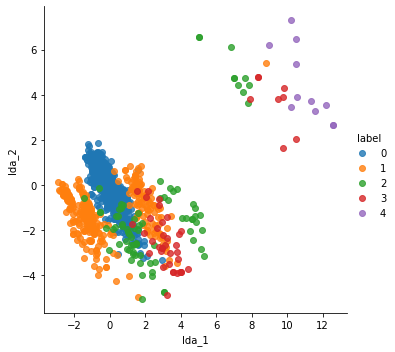

In [16]:
X_train_lda = pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda = pd.concat((X_train_lda, y_label), axis = 1) #X_train_Ida와 y_label 데이터를 하나로 합치기
X_train_lda.columns = ['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x = 'lda_1',y = 'lda_2',data = X_train_lda, hue = 'label', fit_reg = False)
plt.show()

## 우리가 원하는 정답 모양
## 캠페인 참여에서의 총 참여 횟수를 라벨값으로 둔 상태에서의 데이터 분포도

###K-means Clustering

클러스터링을 돌려 보는 데에 의의가 있기에, 파라미터 값 최적화보다는 각 알고리즘을 사용하면 결과가 어떻게 달라지는 지에 초점을 맞추어 살펴봅니다. 여러 번 시행해보면서 **자유롭게 파라미터를 정해주세요**.

**(직접 최적의 파라미터 값을 찾아서 설정하고 싶으시다면 훨씬 좋습니다! 해당 과제의 모든 코드는 기본 뼈대일 뿐입니다. 코드를 추가 또는 변경하셔도 좋습니다.)**

다른 x값들에 대해서도 캠페인 참여도, 즉 고객의 충실도를 잘 군집화할 수 있을까요? 클러스터링으로 결과를 확인해봅시다.



---





K-means를 이용하여 클러스터링 해봅시다.

In [17]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import KMeans

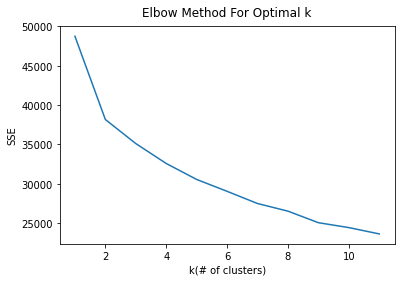

In [23]:
sse = []
K = range(1, 12)
for k in K:
  km = KMeans(n_clusters = k)
  km = km.fit(X_features_scaling)
  sse.append(km.inertia_)

plt.plot(K, sse)
plt.xlabel('k(# of clusters)')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k', pad = 10)
plt.show()

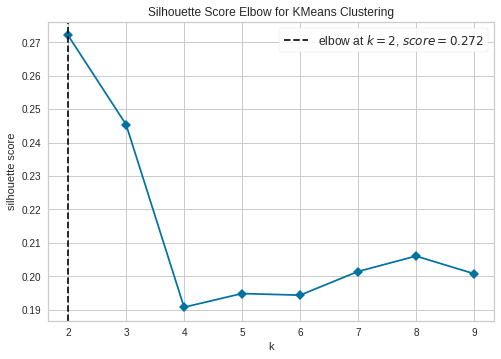

In [24]:
from yellowbrick.cluster import KElbowVisualizer #elbow method
model = KMeans()
elbowvisualizer = KElbowVisualizer(model, k = (2,10), metric = 'silhouette', timings = False)

elbowvisualizer.fit(X_features_scaling)  
elbowvisualizer.show()

k=2일 때 최적의 군집 수를 가짐을 확인할 수 있음. 다만, 앞서 임의로 설정한 라벨 값이 0~4까지 5개이므로, k=5에 대해서도 군집화를 진행함. 

In [45]:
## 클러스터 수는 2로 설정하고, KMeans를 활용하여 예측된 y값을 만들어 봅시다.

km = KMeans(n_clusters = 2)

y_km = km.fit_predict(X_features_scaling)
y_km

array([1, 0, 1, ..., 1, 1, 0], dtype=int32)

In [47]:
X_train_lda['K_means'] = y_km

####시각화

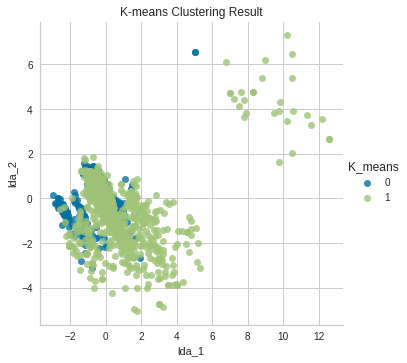

In [48]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'K_means', fit_reg = False)
plt.title('K-means Clustering Result')
plt.show()

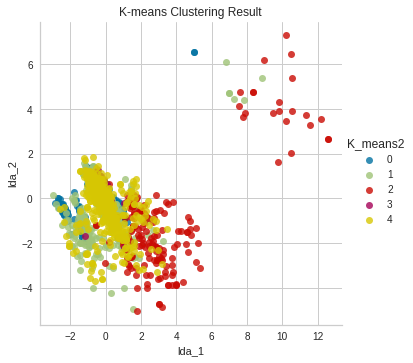

In [88]:
km2 = KMeans(n_clusters = 5)
y_km2 = km2.fit_predict(X_features_scaling)
X_train_lda['K_means2'] = y_km2
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'K_means2', fit_reg = False)
plt.title('K-means Clustering Result')
plt.show()

###Hierarchical Clustering

Agglomerative 방법을 이용하여 클러스터링 해봅시다.

In [89]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import AgglomerativeClustering

In [104]:
## 클러스터 수는 2로 설정하고, Agglomerative를 활용하여 예측된 y값을 만들어 봅시다.

agghc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward') #와드연결법을 사용합니다.

y_agghc = agghc.fit_predict(X_features_scaling)
y_agghc

array([0, 1, 0, ..., 1, 0, 1])

In [105]:
X_train_lda['hierarchical'] = y_agghc

####시각화

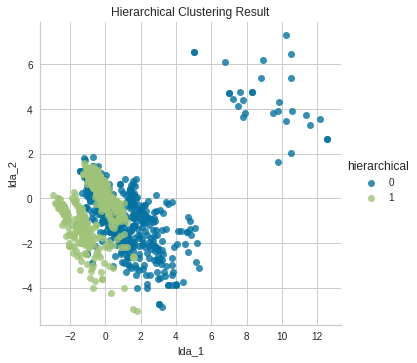

In [106]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'hierarchical', fit_reg = False)
plt.title('Hierarchical Clustering Result')
plt.show()

###DBSCAN

DBSCAN을 이용하여 클러스터링 해봅시다.

In [29]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import DBSCAN

In [31]:
import sklearn.utils
import sklearn.neighbors
from sklearn.neighbors import NearestNeighbors

In [73]:
nb = NearestNeighbors(n_neighbors = 5).fit(X_features_scaling)

In [74]:
minPts = 5

In [75]:
#kneighbors([X, n_neighbors, return_distance]): Find the K-neighbors of a point.
distances, indices = nb.kneighbors(X_features_scaling)

In [76]:
distances #한 점이 minPts를 만족하는 점들과의 거리

array([[1.19209290e-07, 3.34668520e+00, 3.52977034e+00, 3.53985459e+00,
        3.72780375e+00],
       [0.00000000e+00, 9.09903423e-01, 9.39336054e-01, 9.58490843e-01,
        9.79192252e-01],
       [0.00000000e+00, 1.63108673e+00, 1.92351889e+00, 2.01634054e+00,
        2.11188480e+00],
       ...,
       [0.00000000e+00, 2.85466117e+00, 3.02415529e+00, 3.27335510e+00,
        3.45242572e+00],
       [0.00000000e+00, 1.42852458e+00, 1.70955064e+00, 1.75579970e+00,
        2.09230881e+00],
       [0.00000000e+00, 1.14949383e+00, 1.40752549e+00, 1.54215594e+00,
        1.66993056e+00]])

In [77]:
indices

array([[   0, 1177, 1911, 2137,  259],
       [   1, 1869, 1615, 1563,   92],
       [   2,  549, 1107, 1390, 2214],
       ...,
       [2213, 1630, 1236, 1262, 1585],
       [2214, 1107, 1550, 1390,  505],
       [2215, 1569, 1392, 1946,  684]])

In [68]:
len(distance)

2216

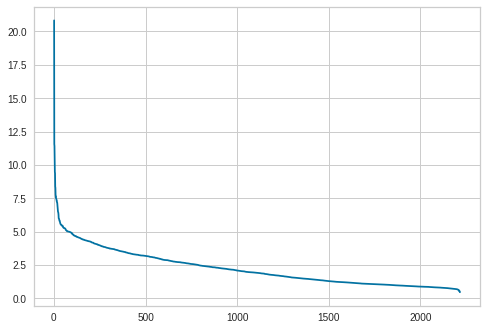

In [78]:
distance = sorted(distances[:, minPts-1], reverse = True)
plt.plot(list(range(1,2217)), distance)

valley가 시작되는 5.0을 eps로 설정한다.

In [85]:
## eps는 5.0, minPts는 4로 설정한 뒤 DBSCAN를 활용하여 예측된 y값을 만들어 봅시다.

dbscan = DBSCAN(eps = 5, min_samples = 4, metric = 'euclidean') #eps는 0-1

y_dbscan = dbscan.fit_predict(X_features_scaling)
y_dbscan

array([0, 0, 0, ..., 0, 0, 0])

In [86]:
X_train_lda['dbscan'] = y_dbscan

In [94]:
cluster_db = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
cluster_db

3

####시각화

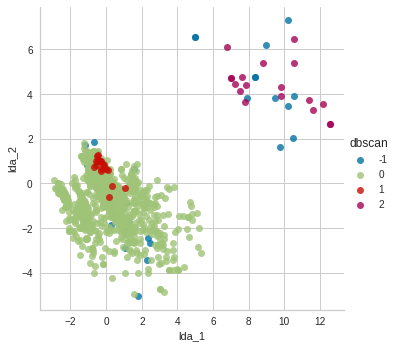

In [87]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'dbscan', fit_reg = False)
plt.show()

###Validation

실루엣 계수를 사용하여 각 클러스터링의 성능을 평가해봅시다.



---



(Q) 실루엣 계수로 평가하기 전에, 육안 상으로 어떠한 알고리즘의 성능이 제일 높아 보이며 어떠한 알고리즘의 성능이 제일 낮아 보이는지 의견을 적어주세요.

K-means : Lda 결과와 유사하게 클러스터링 된 것을 확인할 수 있음. 라벨의 순서는 다소 바뀐 것으로 보이지만, 전체적 군집 경향성은 비슷함.

AGG : K-means와는 다르게 위쪽 축을 기준으로 군집화된 데이터들을 잘 구분하지 못한 것을 확인할 수 있었음. 전체적으로 lda를 정답으로 볼 때, 해당 결과와의 차이가 약간 존재함.

DBSCAN : 완전히 다른 형태를 가지고 분류됨. Label 이 3개라 lda 결과와는 차이가 있음.

따라서 k-means 가 가장 좋은 성능을 보였다고 생각함.



---



이제 실루엣 계수로 성능을 평가해 봅시다!

In [93]:
## 필요한 라이브러리를 임포트합니다.

import sklearn.metrics as metrics
from sklearn.metrics.cluster import silhouette_score

K-means Clustering의 실루엣 계수입니다.

In [103]:
coef_km = metrics.silhouette_score(X_features_scaling, y_km)
print('Silhouette score is {}.'.format(coef_km))

Silhouette score is 0.2731831350380701.


Hierarchical Clustering의 실루엣 계수입니다.

In [107]:
## Hierarchical Clustering

coef_hc = metrics.silhouette_score(X_features_scaling, y_agghc)
print('Silhouette score is {}.'.format(coef_hc))

Silhouette score is 0.24392857890655703.


DBSCAN의 실루엣 계수입니다.

In [101]:
## DBSCAN

coef_db = metrics.silhouette_score(X_features_scaling, y_dbscan)
print('Silhouette score is {}.'.format(coef_db))

Silhouette score is 0.481500951729467.


(Q) 실루엣 계수를 기반으로, 클러스터링 알고리즘의 성능을 높은 순대로 적어주세요.

DBSCAN - KMEANS - Hierarchical

(Q) 클러스터링 결과에 대한 해석을 적어주세요. (참고로, 실루엣 계수는 -1에서 1 사이의 값을 가집니다.)

실루엣 계수가 전체 모델에서 모두 높은 값을 가지지 못한 것을 확인할 수 있었음. 0.5 이상을 적절히 군집화된 결과라고 할 때, 가장 점수가 높은 DBSCAN도 0.48로 좋은 결과는 아니었음. 따라서 변수 제어를 통해 더 나은 데이터셋을 만들어 좋은 결과를 얻기 위해 노력할 필요가 있다고 생각함.


(Q) 마케팅 캠페인과 관련하여 도출할 수 있는 인사이트를 적어주세요.

시각화 결과 우측 상단에 위치하고 있는 고객들은 compaign acceptance가 높은 그룹, 즉 충성 고객이라고 생각할 수 있다. 이렇게 군집된 고객 특성을 분석해보면 충성 고객들이 왜 충성고객이 되었는지를 파악할 수 있고 이를 기반으로 고객 대응 전략을 구축할 수 있을 것이라고 생각한다.